In [41]:
using ModelingToolkit, DomainSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x, t
@variables f₁(..), f₂(..), θ₁(..), θ₂(..), w₁(..), w₂(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

eqs = [
    Dₓ(θ₁(x,t)) - Dₓ²(w₁(x,t)) + Dₜ²(w₁(x,t)) + w₁(x,t) - w₂(x,t) ~ f₁(x,t),
    Dₓ(θ₂(x,t)) - Dₓ²(w₂(x,t)) + Dₜ²(w₂(x,t)) + w₂(x,t) - w₁(x,t) ~ f₂(x,t),
    Dₜ²(θ₁(x,t)) ~ Dₓ²(θ₁(x,t)) + Dₓ(w₁(x,t)) - θ₁(x,t),
    Dₜ²(θ₂(x,t)) ~ Dₓ²(θ₂(x,t)) + Dₓ(w₂(x,t)) - θ₂(x,t),
]

bcs = [
    θ₁(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ₁(x, 0.0)) ~ 0.0,
    w₁(x, 0.0) ~ π/2*sin(x),
    Dₜ(w₁(x, 0.0)) ~ 0.0,
    θ₂(x, 0.0) ~ cos(x) + 2/π * x - 1,
    Dₜ(θ₂(x, 0.0)) ~ 0.0,
    w₂(x, 0.0) ~ sin(x),
    Dₜ(w₂(x, 0.0)) ~ 0.0,
    θ₁(0.0, t) ~ 0.0,
    θ₁(π, t) ~ 0.0,
    w₁(0.0, t) ~ 0.0,
    w₁(π, t) ~ 0.0,
    θ₂(0.0, t) ~ 0.0,
    θ₂(π, t) ~ 0.0,
    w₂(0.0, t) ~ 0.0,
    w₂(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo_double = PDESystem(eqs, bcs, domains, [x,t], [f₁,f₂,θ₁,θ₂,w₁,w₂])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(w₁(x, t))) + Differential(x)(θ₁(x, t)) + w₁(x, t) - Differential(x)(Differential(x)(w₁(x, t))) - w₂(x, t) ~ f₁(x, t), Differential(t)(Differential(t)(w₂(x, t))) + Differential(x)(θ₂(x, t)) + w₂(x, t) - Differential(x)(Differential(x)(w₂(x, t))) - w₁(x, t) ~ f₂(x, t), Differential(t)(Differential(t)(θ₁(x, t))) ~ Differential(x)(Differential(x)(θ₁(x, t))) + Differential(x)(w₁(x, t)) - θ₁(x, t), Differential(t)(Differential(t)(θ₂(x, t))) ~ Differential(x)(Differential(x)(θ₂(x, t))) + Differential(x)(w₂(x, t)) - θ₂(x, t)]
Boundary Conditions: Equation[θ₁(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ₁(x, 0.0)) ~ 0.0, w₁(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w₁(x, 0.0)) ~ 0.0, θ₂(x, 0.0) ~ 0.6366197723675814x + cos(x) - 1, Differential(t)(θ₂(x, 0.0)) ~ 0.0, w₂(x, 0.0) ~ sin(x), Differential(t)(w₂(x, 0.0)) ~ 0.0, θ₁(0.0, t) ~ 0.0, θ₁(π, t) ~ 0.0, w₁(0.0, t) ~ 0.0, w₁(π, t) ~ 0.0, θ₂(0.

In [67]:
pinn = PINN(θ₁ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            θ₂ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            w₁ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            w₂ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            f₁ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1),
            f₂ = Siren(2,1; hidden_dims=16,num_layers=4,omega=1))

sampler = QuasiRandomSampler(2000, (ntuple(Returns(500),8)..., ntuple(Returns(200),8)...))
strategy = NonAdaptiveTraining(1, 10)

prob = Sophon.discretize(timo_double, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [0.12068045139312744 0.26710641384124756; -0.09630399942398071 0.48677361011505127; … ; 0.20975548028945923 0.4704062342643738; 0.3141540288925171 -0.1459408402442932], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.5332583785057068 0.5666900277137756 … 0.6118717789649963 0.16550923883914948; -0.3590830862522125 0.09173765778541565 … 0.4544556438922882 0.4684356153011322; … ; 0.5270542502403259 0.2991428077220917 … -0.1715979129076004 -0.059301719069480896; -0.30799800157546997 -0.020086374133825302 … 0.30604588985443115 -0.11528535187244415], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.13258515298366547 -0.1393709033727646 … 0.4362078607082367 0.22172829508781433; 0.16150319576263428 0.417623907327652 … 0.22011804580688477 0.5556350350379944; … ; -0.1597679704427719 0.3377121090888977 … 0.28536421060562134 -0.1825317144393921; 0.4305773377418518 0.3015982508659363 … -

In [68]:
function callback(p, l)
   # println("Loss: $l")
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

u: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [-0.2098948214149481 0.1973501143763115; -0.12821886444201863 0.33919899402787773; … ; 0.23389500336736746 0.5190607519489374; 0.24967340697309037 -0.09739826729149863], bias = [-0.026345320807750348; 0.1585466414767111; … ; -0.34076282592172197; 0.1445646547667665;;]), layer_2 = (weight = [-0.41868029875860524 0.5705735520869718 … 0.5684663460299915 0.0888511930810078; -0.3497729901540029 0.12445795840614857 … 0.5176995770328914 0.48492845585151906; … ; 0.5103164932562037 0.30750410394999517 … -0.24844476410524585 -0.0964130795961415; -0.37203483118592123 -0.09473607167059672 … 0.311074382712908 -0.050116042602517924], bias = [0.32286859609704327; 0.06423507971074303; … ; 0.12512964601758358; -0.04980155250543884;;]), layer_3 = (weight = [0.16067945762057045 -0.1081822964726234 … 0.41389689664105317 0.1884985399747074; 0.3619690486650276 0.4174007931013078 … 0.26002848322174127 0.5659848538475406; … ; -0.3751236629452237 0.35201042

In [81]:
res.objective

1.5044355113973434e-7

In [73]:
data = Sophon.sample(timo_double, sampler)
prob = remake(prob; u0=res.u, p=data)
res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

u: ComponentVector{Float64}(θ₁ = (layer_1 = (weight = [-0.2547250892158966 0.14383486803168716; -0.13999253057869046 0.37697681494797103; … ; 0.29006179265245813 0.5169883555553999; 0.19313447716725712 -0.09703883385768851], bias = [-0.026631132652268602; 0.2343871416504705; … ; -0.3890427581637465; 0.120498961666118;;]), layer_2 = (weight = [-0.4355985957935933 0.5438210571459202 … 0.46558997136724206 0.0977722168343096; -0.3528500204054263 0.11685282440798593 … 0.5024492091056293 0.481381835177205; … ; 0.5241437663122441 0.35023262154747375 … -0.2264604182825099 -0.10583744064858297; -0.3546393929293416 -0.09287397318322768 … 0.31928774429002904 -0.05720896607346524], bias = [0.3595892353165372; 0.08514825844618686; … ; 0.15274517238351396; -0.03947579932931815;;]), layer_3 = (weight = [0.1274930364736931 -0.0902954583690446 … 0.41695165159650904 0.18446616119930268; 0.36330634671616 0.4397981142121229 … 0.2628366091019788 0.556024226010236; … ; -0.40903741119152087 0.389056125349701

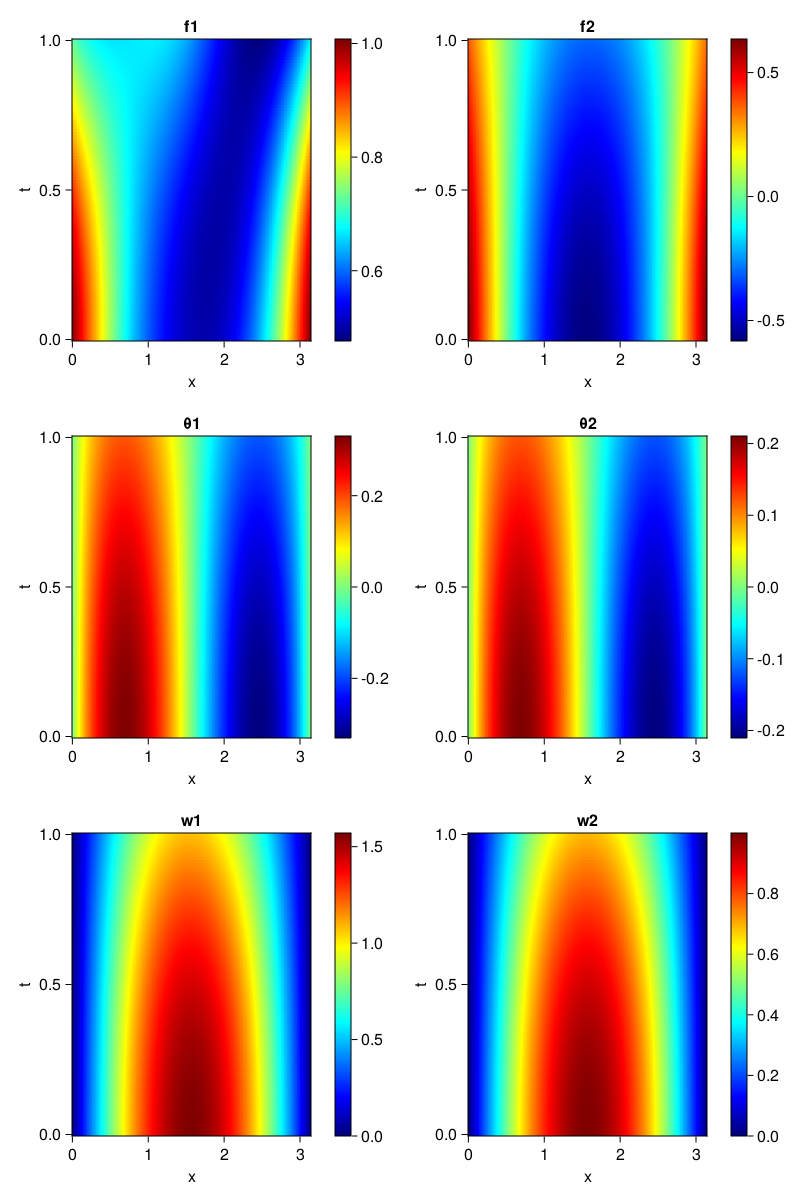

In [79]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo.domain]

f₁ = [sum(phi.f₁(([x,t]), ps.f₁)) for x in xs, t in ts]
f₂ = [sum(phi.f₂(([x,t]), ps.f₂)) for x in xs, t in ts]
θ₁ = [sum(phi.θ₁(([x,t]), ps.θ₁)) for x in xs, t in ts]
θ₂ = [sum(phi.θ₂(([x,t]), ps.θ₂)) for x in xs, t in ts]
w₁ = [sum(phi.w₁(([x,t]), ps.w₁)) for x in xs, t in ts]
w₂ = [sum(phi.w₂(([x,t]), ps.w₂)) for x in xs, t in ts]

fig = Figure(resolution=(800,1200))
axis = (xlabel="x", ylabel="t", title="f1")

_, hm1 = heatmap(fig[1, 1], xs, ts, f₁, axis=axis, colormap=:jet)
Colorbar(fig[1, 2], hm1)
_, hm2 = heatmap(fig[1, 3], xs, ts, f₂, axis= merge(axis, (; title="f2")), colormap=:jet)
Colorbar(fig[1, 4], hm2)
_, hm3 = heatmap(fig[2, 1], xs, ts, θ₁, axis= merge(axis, (; title="θ1")), colormap=:jet)
Colorbar(fig[2, 2], hm3)
_, hm4 = heatmap(fig[2, 3], xs, ts, θ₂, axis= merge(axis, (; title="θ2")), colormap=:jet)
Colorbar(fig[2, 4], hm4)
_, hm5 = heatmap(fig[3, 1], xs, ts, w₁, axis= merge(axis, (; title="w1")), colormap=:jet)
Colorbar(fig[3, 2], hm5)
_, hm6 = heatmap(fig[3, 3], xs, ts, w₂, axis= merge(axis, (; title="w2")), colormap=:jet)
Colorbar(fig[3, 4], hm6)

display(fig)

In [78]:
f₁_analytic(x,t) = cos(t)*(1-sin(x))
f₂_analytic(x,t) = 2/π * cos(t)*(1-sin(x))
θ₁_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t) 
θ₂_analytic(x,t) = (cos(x) + 2/π * x - 1)*cos(t)
w₁_analytic(x,t) = π/2*sin(x)*cos(t)
w₂_analytic(x,t) = sin(x)*cos(t)

w₂_analytic (generic function with 1 method)

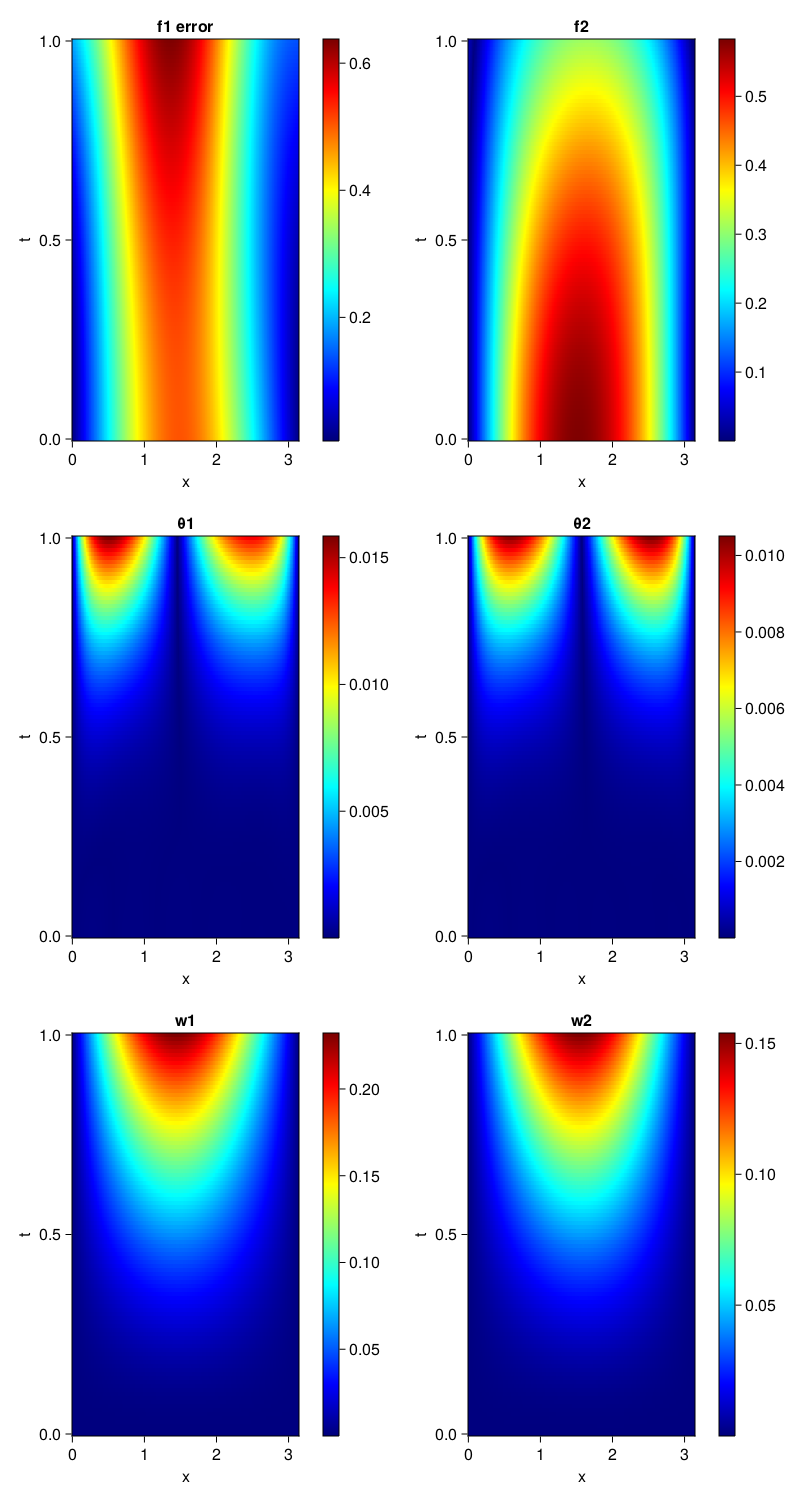

In [80]:
f₁_true = [f₁_analytic(x,t) for x in xs, t in ts]
f₂_true = [f₂_analytic(x,t) for x in xs, t in ts]
θ₁_true = [θ₁_analytic(x,t) for x in xs, t in ts]
θ₂_true = [θ₂_analytic(x,t) for x in xs, t in ts]
w₁_true = [w₁_analytic(x,t) for x in xs, t in ts]
w₂_true = [w₂_analytic(x,t) for x in xs, t in ts]

fig = Figure(resolution=(800,1500))
axis = (xlabel="x", ylabel="t", title="f1 error")

_, hm1 = heatmap(fig[1, 1], xs, ts, abs.(f₁ .- f₁_true), axis=axis, colormap=:jet)
Colorbar(fig[1, 2], hm1)
_, hm2 = heatmap(fig[1, 3], xs, ts, abs.(f₂ .- f₂_true), axis= merge(axis, (; title="f2")), colormap=:jet)
Colorbar(fig[1, 4], hm2)

_, hm3 = heatmap(fig[2, 1], xs, ts, abs.(θ₁ .- θ₁_true), axis= merge(axis, (; title="θ1")), colormap=:jet)
Colorbar(fig[2, 2], hm3)
_, hm4 = heatmap(fig[2, 3], xs, ts, abs.(θ₂ .- θ₂_true), axis= merge(axis, (; title="θ2")), colormap=:jet)
Colorbar(fig[2, 4], hm4)

_, hm5 = heatmap(fig[3, 1], xs, ts, abs.(w₁ .- w₁_true), axis= merge(axis, (; title="w1")), colormap=:jet)
Colorbar(fig[3, 2], hm5)
_, hm6 = heatmap(fig[3, 3], xs, ts, abs.(w₂ .- w₂_true), axis= merge(axis, (; title="w2")), colormap=:jet)
Colorbar(fig[3, 4], hm6)


display(fig)